## Load and filter classes

In [1]:
import pandas as pd

classes_file = "../dataset/class_labels_indices.csv"
selected_classes = ["Vehicle horn, car horn, honking", "Children playing", "Dog", "Jackhammer", "Siren", 
                    "Traffic noise, roadway noise", "Subway, metro, underground", "Walk, footsteps", "Chatter", "Bird"]
df = pd.read_csv(classes_file)
df.set_index("index", inplace=True)
selected_classes_indexes = df.index[df['display_name'].isin(selected_classes)].tolist()
print(selected_classes_indexes)

[53, 68, 71, 74, 111, 308, 327, 334, 396, 420]


In [2]:
import os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def extract_features(dataset_dir):
    X = []
    y = []
    recordset = os.listdir(dataset_dir)
    for record in recordset:
        raw_dataset = tf.data.TFRecordDataset(dataset_dir+record)    
        for raw_record in raw_dataset.take(1):
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            labels = example.features.feature['labels'].int64_list.value
            # print(labels)

            for label in labels:
                if label in selected_classes_indexes:
                    # video = example.features.feature['video_id'].bytes_list.value[0].decode("utf-8")
                    # start = example.features.feature['start_time_seconds'].float_list.value[0]
                    # end = example.features.feature['end_time_seconds'].float_list.value[0]
                    # print(f"Video: {video}")
                    # print(f"Duration: {end-start} seconds")
                    
                    labels_detected = set(labels).intersection(set(selected_classes_indexes))
                    # print(f"Labels: ", labels_detected)
                    
                    example_seq = tf.train.SequenceExample()
                    example_seq.ParseFromString(raw_record.numpy())
                    
                    try:
                        i=0
                        feats_list = example_seq.feature_lists.feature_list['audio_embedding']
                        while True:
                            hex_features = feats_list.feature[i].bytes_list.value[0].hex()
                            features_array = [int(hex_features[k:k+2],16) for k in range(0,len(hex_features),2)]
                            # for l in labels_detected:
                                # If there's more than one of the selected labels in the video
                            X.append(features_array)
                            y.append(list(labels_detected))
                            i += 1
                    except IndexError as ie:
                            #FeatureList does not have length, so we read until the end
                            continue
                            
    X = np.array(X)/255
    y = np.array(y, dtype=object)
    
    # Apply OneHotEncodig to ground truth
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(y)

    # We need to add at least one dimension to our X   
    X = X.reshape(X.shape[0], 128, 1)
    return X,y

In [3]:
# Extract data for training
X_train, y_train = extract_features("../dataset/audioset_v1_embeddings/bal_train/")

print(X_train.shape, y_train.shape)

(1978, 128, 1) (1978, 10)


In [4]:
# Extract also X and y for validation
X_val, y_val = extract_features("../dataset/audioset_v1_embeddings/eval/")
print(X_val.shape, y_val.shape)

(2233, 128, 1) (2233, 10)


# Define neural network for classification
We need a neural network with 128 inputs and 10 outputs (one for each audio class). As each audio could be multilabelled, it is not recommended to use softmax as output layer but sigmoid (https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

model = Sequential([
    #Conv1D(32, 3, padding="same", input_shape=X_train[0].shape, activation="relu", name="input"),
    Conv1D(128, 3, padding="same", input_shape=X_train[0].shape, activation="relu", name="input"),
    MaxPool1D(pool_size=2, name="maxpool1"),
    
    #Conv1D(64, 3, padding="same", activation="relu", name="conv1D_1"),
    Conv1D(128, 3, padding="same", activation="relu", name="conv1D_1"),
    MaxPool1D(pool_size=2, name="maxpool2"),
    
    #Conv1D(128, 3, padding="same", activation="relu", name="conv1D_2"),
    Conv1D(64, 3, padding="same", activation="relu", name="conv1D_2"),
    MaxPool1D(pool_size=2, name="maxpool3"),
    
    # Conv1D(256, 3, padding="same", activation="relu", name="conv1D_3"),
    # MaxPool1D(pool_size=2, name="maxpool4"),
      
    Flatten(name="flatten"),
    Dense(1024, activation="relu", name="dense"),
    
    Dense(len(selected_classes_indexes), activation="sigmoid", name="output")
])

opt = Adam(learning_rate=0.0001)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv1D)              (None, 128, 128)          512       
                                                                 
 maxpool1 (MaxPooling1D)     (None, 64, 128)           0         
                                                                 
 conv1D_1 (Conv1D)           (None, 64, 128)           49280     
                                                                 
 maxpool2 (MaxPooling1D)     (None, 32, 128)           0         
                                                                 
 conv1D_2 (Conv1D)           (None, 32, 64)            24640     
                                                                 
 maxpool3 (MaxPooling1D)     (None, 16, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

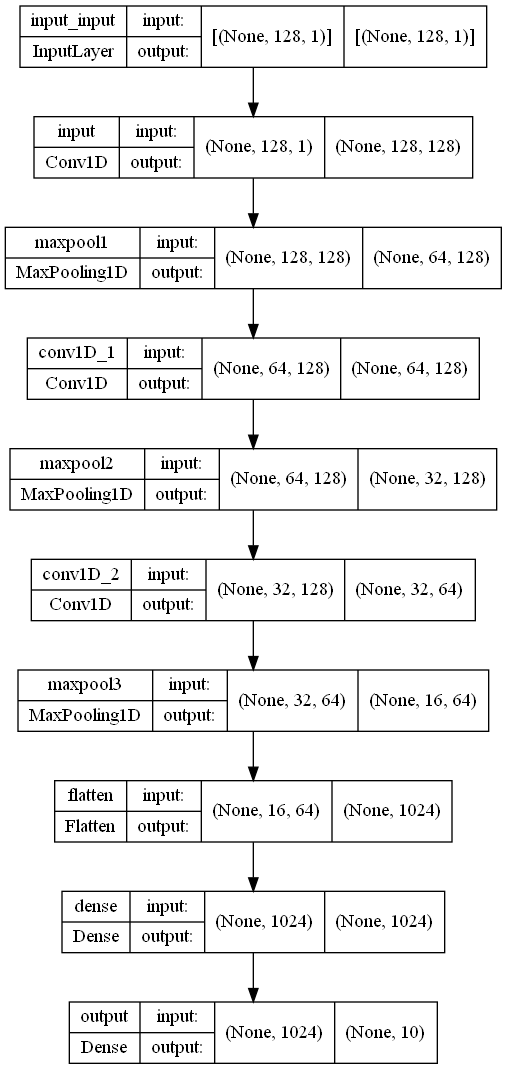

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [7]:
# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 11s 37ms/step - loss: 2.1046 - accuracy: 0.2649 - val_loss: 2.1935 - val_accuracy: 0.2835
Epoch 2/20
62/62 [==============================] - 1s 13ms/step - loss: 2.0227 - accuracy: 0.3008 - val_loss: 2.1628 - val_accuracy: 0.2056
Epoch 3/20
62/62 [==============================] - 1s 13ms/step - loss: 1.9460 - accuracy: 0.3645 - val_loss: 2.0647 - val_accuracy: 0.3193
Epoch 4/20
62/62 [==============================] - 1s 13ms/step - loss: 1.7777 - accuracy: 0.4050 - val_loss: 1.8779 - val_accuracy: 0.3887
Epoch 5/20
62/62 [==============================] - 1s 12ms/step - loss: 1.5517 - accuracy: 0.4717 - val_loss: 1.7193 - val_accuracy: 0.4532
Epoch 6/20
62/62 [==============================] - 1s 13ms/step - loss: 1.3155 - accuracy: 0.5683 - val_loss: 1.6103 - val_accuracy: 0.4850
Epoch 7/20
62/62 [==============================] - 1s 13ms/step - loss: 1.1618 - accuracy: 0.6153 - val_loss: 1.5412 - val_accuracy: 0.5137
Epoch 8/20
6

In [8]:
model.save("pokemon_model_trained.h5")

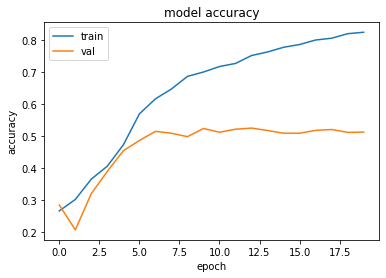

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

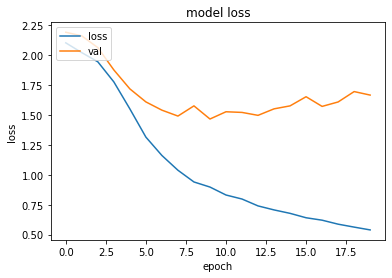

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [11]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Resizing, Normalization, Conv2D, MaxPooling2D, Dropout

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=X_train)

model2 = Sequential([
    input_shape=X_train[0].shape,
    # Downsample the input.
    # Resizing(32, 32),
    # Normalize.
    norm_layer,
    Conv1D(32, 3, activation='relu'),
    Conv1D(64, 3, activation='relu'),
    MaxPool1D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes_indexes)),
])

model2.summary()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1343688098.py, line 11)

In [ ]:
# Compile
model2.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history2 = model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

In [ ]:
# Esta red no funciona bien, se descarta

In [12]:
import keras

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model2 = build_model(X_train[0].shape, len(selected_classes_indexes))

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 128, 16)      64          ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 128, 16)      0           ['conv1d_1[0][0]']               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 128, 16)      784         ['activation[0][0]']             
                                                                                              

 conv1d_14 (Conv1D)             (None, 8, 128)       16512       ['max_pooling1d_3[0][0]']        
                                                                                                  
 add_4 (Add)                    (None, 8, 128)       0           ['conv1d_17[0][0]',              
                                                                  'conv1d_14[0][0]']              
                                                                                                  
 activation_12 (Activation)     (None, 8, 128)       0           ['add_4[0][0]']                  
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 4, 128)      0           ['activation_12[0][0]']          
                                                                                                  
 average_pooling1d (AveragePool  (None, 1, 128)      0           ['max_pooling1d_4[0][0]']        
 ing1D)   

In [13]:
# Compile
model2.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history2 = model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 5s 46ms/step - loss: 2.1037 - accuracy: 0.2270 - val_loss: 2.2201 - val_accuracy: 0.2029
Epoch 2/20
62/62 [==============================] - 1s 20ms/step - loss: 2.0737 - accuracy: 0.2376 - val_loss: 2.2034 - val_accuracy: 0.2029
Epoch 3/20
62/62 [==============================] - 1s 21ms/step - loss: 2.0689 - accuracy: 0.2417 - val_loss: 2.2004 - val_accuracy: 0.2029
Epoch 4/20
62/62 [==============================] - 1s 24ms/step - loss: 2.0465 - accuracy: 0.2781 - val_loss: 2.1701 - val_accuracy: 0.2682
Epoch 5/20
62/62 [==============================] - 1s 21ms/step - loss: 1.8736 - accuracy: 0.3504 - val_loss: 1.9302 - val_accuracy: 0.3050
Epoch 6/20
62/62 [==============================] - 1s 21ms/step - loss: 1.6999 - accuracy: 0.3883 - val_loss: 1.8920 - val_accuracy: 0.2996
Epoch 7/20
62/62 [==============================] - 1s 23ms/step - loss: 1.6256 - accuracy: 0.3898 - val_loss: 1.7921 - val_accuracy: 0.3175
Epoch 8/20
62

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
keras.backend.clear_session()


def build_and_compile_model():
    inputs = keras.layers.Input(X_train[0].shape, name="embedding")

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)
    x = keras.layers.Flatten()(x)

    outputs = keras.layers.Dense(len(selected_classes_indexes), activation="softmax", name="ouput")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="sound_recognition")

    model.compile(
        optimizer=Adam(learning_rate=1.9644e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

    return model


model3 = build_and_compile_model()
model3.summary()

In [ ]:
history3 = model3.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

In [ ]:
model3.save("Keras_audio.h5")

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x = X_val[9]
print(x.shape, x)

new_model = tf.keras.models.load_model("Keras_audio.h5")
new_model.predict(x)

In [ ]:
from keras.models import load_model

model5 = load_model('Keras_audio.h5')

In [ ]:
t = tf.constant(X_train[9])

In [ ]:
X_train[0].shape

In [ ]:
model5.predict(t)